`EffnetMultiHead`

successfully combines **Transfer Learning, Multimodal Fusion, and Multi-Head Architecture**. This makes it highly efficient and robust for complex predictive tasks where multiple related outputs are needed.

### **1. High-Efficiency Feature Extraction (Transfer Learning)**

* **The Backbone:** The model uses `efficientnet_b0` as its base. [cite_start]EfficientNet models are known for being very accurate while requiring fewer computational resources than many other traditional models[cite: 368].
* **Transfer Learning:** By loading pre-trained weights (`weights="IMAGENET1K_V1"`), the model starts its training process with generalized knowledge about visual features (edges, textures, patterns) already learned from the massive ImageNet dataset. [cite_start]This significantly **reduces training time and data requirements**[cite: 787].
* **Feature Extraction Focus:** Like in the previous model, the original classification head is replaced by an identity function (`self.backbone.classifier = nn.Identity()`). This forces the EfficientNet to act purely as a powerful **feature extractor**, outputting a clean visual embedding (`img_emb`).

### **2. Multimodal Data Fusion**

* **Separate Processing:** The model processes the visual data (`img_emb`) and the tabular data (`tab_mlp`) separately, allowing each component to specialize.
    * The `tab_mlp` converts the raw numerical data (`num_tab_features`) into a compact, learned vector (`tab_emb`).
* **Shared Representation (Fusion):** The visual and tabular embeddings are joined (`torch.cat`) and fed into a `self.shared` linear layer. [cite_start]This layer learns the complex initial interactions between the two modalities (images and numbers), forming a single **multimodal shared representation**[cite: 1709]. This fusion is crucial because the performance of the prediction depends on how these features influence each other.

### **3. Multi-Head Architecture (Specialization)**

* **Core Concept:** This is the most powerful aspect of the design. Instead of forcing all targets (e.g., "biomass," "moisture," "carbon") into a single output layer, the model uses a separate, dedicated "head" for each target group (`self.heads`).
* **Why it's highly effective:**
    * [cite_start]**Task Specialization:** Each head is a dedicated mini-MLP that refines the shared multimodal features specifically for its unique task[cite: 1251]. For example, the features important for predicting "moisture" might be different from those important for predicting "biomass." This specialization leads to **higher accuracy** compared to a single large head.
    * [cite_start]**Independent Optimization:** The model can be thought of as performing **multi-task learning**[cite: 672]. During training, the gradients for one head (e.g., "moisture") only directly affect that head, preventing interference with other related but distinct tasks (e.g., "carbon").
    * **Flexibility:** The architecture easily accommodates different output types (e.g., "biomass" requires 2 outputs for classification, while "moisture" requires 1 output for regression).
    * [cite_start]**Shared Knowledge:** All heads benefit from the comprehensive feature extraction of the EfficientNet backbone and the general multimodal learning in the `self.shared` layer[cite: 1726, 1727]. This ensures efficiency as the foundational calculations are not repeated.

**In summary:** The `EffnetMultiHead` is good because it builds on established efficient vision models, adds crucial external data via fusion, and finishes with a specialized multi-head design that guarantees highly accurate and specialized predictions for multiple related outputs.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import cv2
import time
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from torchvision import models, transforms
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Data

In [3]:
# train = pd.read_csv("/Users/alina/Documents/Alina/education/kse/deep-learning/CSIRO-Image2Biomass-Prediction/notebooks/kaggle/input/csiro-biomass/train.csv")
train = pd.read_csv("/kaggle/input/csiro-biomass/train.csv")

In [4]:
print(train.shape)
train.head(10)

(1785, 9)


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000
6,ID1012260530__Dry_Dead_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Dead_g,0.0000
7,ID1012260530__Dry_Green_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Green_g,7.6000
8,ID1012260530__Dry_Total_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Total_g,7.6000
9,ID1012260530__GDM_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,GDM_g,7.6000


In [5]:
train.columns

Index(['sample_id', 'image_path', 'Sampling_Date', 'State', 'Species',
       'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'target'],
      dtype='object')

Regarding the wide format, we use it because we have to predict 5 numbers at once, and in the long format, one row = one target, CNN receives an image and expects to return a vector of 5 numbers. If we distribute it across train/val, it's a bit tricky because we might accidentally put it in the wrong place and cause a data leak. By the way, the submission also has a wide logic. 

In [6]:
train_wide = train.pivot_table(
    index=['image_path', 'Sampling_Date', 'State', 'Species','Pre_GSHH_NDVI', 'Height_Ave_cm'],
    columns='target_name',
    values='target',
    aggfunc='first').reset_index()

In [7]:
train_wide.head()

target_name,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605


In [8]:
train_wide.shape

(357, 11)

In [9]:
train_wide.isna().sum()

target_name
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
Dry_Clover_g     0
Dry_Dead_g       0
Dry_Green_g      0
Dry_Total_g      0
GDM_g            0
dtype: int64

In [10]:
im = cv2.imread('/kaggle/input/csiro-biomass/train/ID1012260530.jpg')

print(type(im))
print(im.shape)
print(type(im.shape))
h, w, c = im.shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)

<class 'numpy.ndarray'>
(1000, 2000, 3)
<class 'tuple'>
width:   2000
height:  1000
channel: 3


In [11]:
train_wide.describe()

target_name,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,0.657423,7.595985,6.649692,12.044548,26.624722,45.318097,33.274414
std,0.152142,10.285262,12.117761,12.402007,25.401232,27.984015,24.935822
min,0.160000,1.000000,0.000000,0.000000,0.000000,1.040000,1.040000
25%,0.560000,3.000000,0.000000,3.200000,8.800000,25.271500,16.026100
50%,0.690000,4.000000,1.423500,7.980900,20.800000,40.300000,27.108200
75%,0.770000,7.000000,7.242900,17.637800,35.083400,57.880000,43.675700
max,0.910000,70.000000,71.786500,83.840700,157.983600,185.700000,157.983600


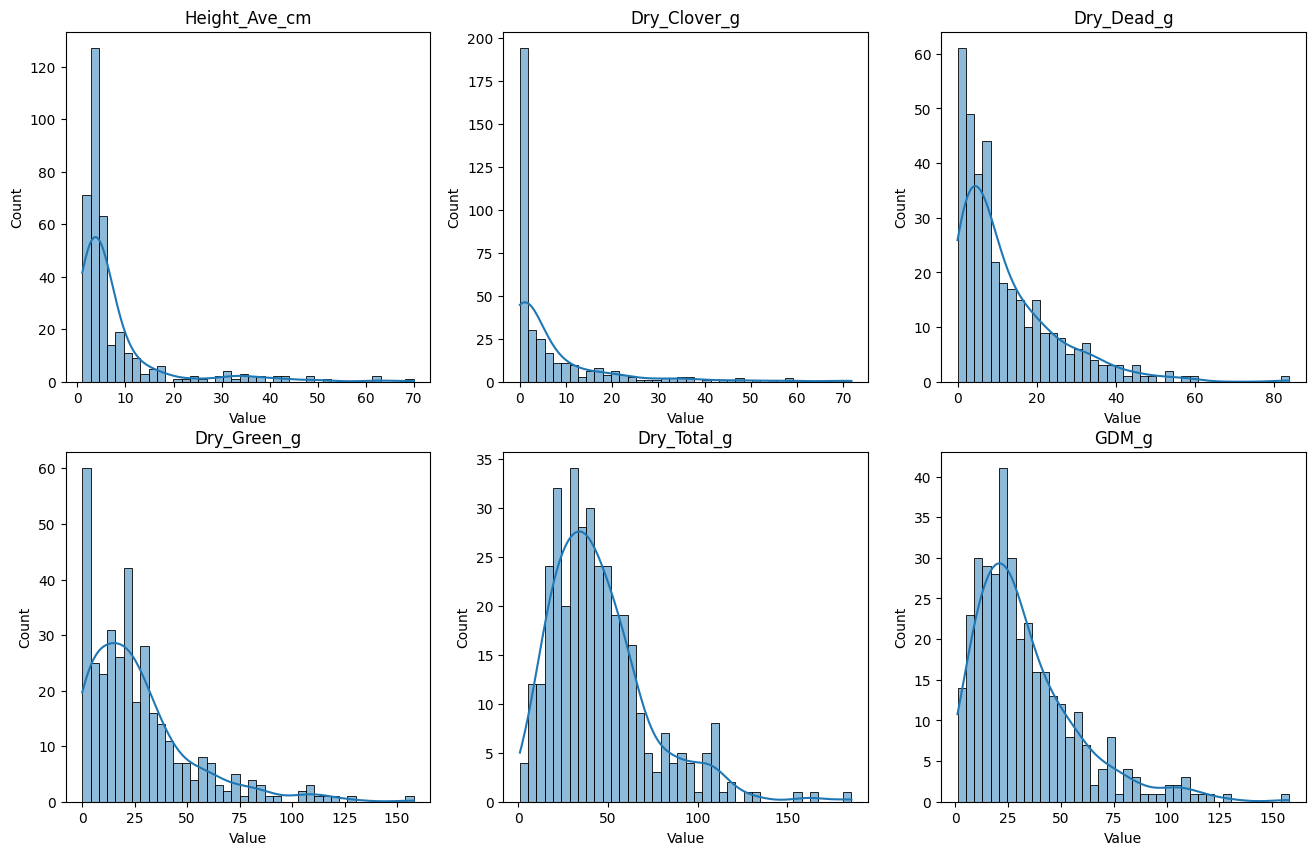

In [12]:
targets = ["Height_Ave_cm","Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

plt.figure(figsize=(16, 10))
for i, t in enumerate(targets):
    plt.subplot(2, 3, i+1)
    sns.histplot(train_wide[t], kde=True, bins=40)
    plt.title(t)
    plt.xlabel("Value")
    plt.ylabel("Count")

# Some Ideas

- Data is LIMITED => CNN needs TTA, strong augmentations, pretrained models
- NDVI: mean 0.66, min 0.16, max 0.91 => very informative, indicates the degree of "greenness" and health of plants
- Height_Ave_cm: the most values are small, so i would use log transform or Box-Cox
- Dry_Clover_g: this is GABELLA, 25% = 0, 50% = 1.4235, it will be difficult to predict this target
- Dry_Dead_g & Dry_Green_g: if there is a lot of green mass => usually less dead mass, if there is little green mass => there will be more dead mass or soil. I believe CNN must take this dependency into account.
- Dry_Total_g: our most important target in the competition because it has a weight=0.5 in the metric, so the model must be particularly accurate here. 

# More Efficient way

### Log transform

In [13]:
target_cols = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

for col in target_cols:
    train_wide[col + "_log"] = np.log1p(train_wide[col])

target_cols_log = [c + "_log" for c in target_cols]

train_wide["Height_log"] = np.log1p(train_wide["Height_Ave_cm"])
tab_cols = ["Pre_GSHH_NDVI", "Height_log"]

train_wide.describe()

target_name,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g,Dry_Clover_g_log,Dry_Dead_g_log,Dry_Green_g_log,Dry_Total_g_log,GDM_g_log,Height_log
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,0.657423,7.595985,6.649692,12.044548,26.624722,45.318097,33.274414,1.174004,2.087335,2.807202,3.651970,3.273909,1.794954
std,0.152142,10.285262,12.117761,12.402007,25.401232,27.984015,24.935822,1.246057,1.076524,1.186633,0.643380,0.763890,0.739984
min,0.160000,1.000000,0.000000,0.000000,0.000000,1.040000,1.040000,0.000000,0.000000,0.000000,0.712950,0.712950,0.693147
25%,0.560000,3.000000,0.000000,3.200000,8.800000,25.271500,16.026100,0.000000,1.435085,2.282382,3.268485,2.834747,1.386294
50%,0.690000,4.000000,1.423500,7.980900,20.800000,40.300000,27.108200,0.885213,2.195100,3.081910,3.720862,3.336061,1.609438
75%,0.770000,7.000000,7.242900,17.637800,35.083400,57.880000,43.675700,2.109352,2.925192,3.585833,4.075501,3.799430,2.079442
max,0.910000,70.000000,71.786500,83.840700,157.983600,185.700000,157.983600,4.287530,4.440775,5.068801,5.229503,5.068801,4.262680


In [14]:
target_groups = {
    "dry_components": 3,   # Clover, Dead, Green
    "total_biomass": 1,    # Dry_Total
    "gdm": 1               # GDM
}

target_group_cols = {
    "dry_components": ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g"],
    "total_biomass": ["Dry_Total_g"],
    "gdm": ["GDM_g"]
}

### Weighted MSE & Competition r2

In [15]:
weights_dict = {
    "Dry_Green_g": 0.1,
    "Dry_Dead_g": 0.1,
    "Dry_Clover_g": 0.1,
    "GDM_g": 0.2,
    "Dry_Total_g": 0.5,
}

weight_vec_np = np.array([weights_dict[c] for c in target_cols], dtype=float)
weight_vec_torch = torch.tensor(weight_vec_np, dtype=torch.float32).to(device)

In [16]:
def weighted_mse_loss(pred, target, weights: torch.Tensor):
    # pred, target: (batch, 5), weights: (5,)
    diff2 = (pred - target) ** 2
    return (diff2 * weights.view(1, -1)).mean()

In [17]:
def consistency_loss(preds_log):
    preds = torch.expm1(preds_log)

    sum_components = (
        preds[:, 0] +  # Dry_Clover
        preds[:, 1] +  # Dry_Dead
        preds[:, 2]    # Dry_Green
    )

    total = preds[:, 3]  # Dry_Total

    return torch.mean((sum_components - total) ** 2)

In [18]:
def multihead_loss(preds, targets, target_group_cols, target_cols):
    loss = 0.0
    for head_name, cols in target_group_cols.items():
        idxs = [target_cols.index(c) for c in cols]
        y_true = targets[:, idxs]
        y_pred = preds[head_name]
        loss += F.mse_loss(y_pred, y_true)
    return loss

In [19]:
def competition_r2(y_true, y_pred, weight_vec_np):
    """
    y_true, y_pred: (n_samples, n_targets) в ГРАМАХ, не в логах
    weight_vec_np: (n_targets,)
    """
    n_samples, n_targets = y_true.shape
    W = np.tile(weight_vec_np.reshape(1, -1), (n_samples, 1))  # (n_samples, n_targets)

    y_true_flat = y_true.ravel()
    y_pred_flat = y_pred.ravel()
    w_flat = W.ravel()

    y_mean = np.average(y_true_flat, weights=w_flat)

    rss = np.sum(w_flat * (y_true_flat - y_pred_flat) ** 2)
    tss = np.sum(w_flat * (y_true_flat - y_mean) ** 2)

    return 1.0 - rss / (tss + 1e-9)

### Augment

In [20]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.10,
        hue=0.03
    ),
    
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

In [21]:
class PastureDataset(Dataset):
    def __init__(self, df, target_cols_log, tab_cols, transform=None,
                 base_dir="/kaggle/input/csiro-biomass/"):
        self.df = df.reset_index(drop=True)
        self.target_cols_log = target_cols_log
        self.tab_cols = tab_cols
        self.transform = transform
        self.base_dir = base_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.base_dir, row["image_path"])
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        # табличні фічі
        tab_feats = row[self.tab_cols].values.astype("float32")
        tab_feats = torch.from_numpy(tab_feats)

        # лог-таргети
        targets_log = row[self.target_cols_log].values.astype("float32")
        targets_log = torch.from_numpy(targets_log)

        return image, tab_feats, targets_log


### EffnetMultiHead

In [22]:
class EffnetMultiHead(nn.Module):
    def __init__(self, num_tab_features, target_groups):
        super().__init__()

        self.backbone = efficientnet_b0(weights="IMAGENET1K_V1")
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        self.tab_mlp = nn.Sequential(
            nn.Linear(num_tab_features, 32),
            nn.GELU(),
            nn.Linear(32, 16)
        )

        self.shared = nn.Sequential(
            nn.Linear(in_features + 16, 512),
            nn.GELU()
        )

        # heads
        self.heads = nn.ModuleDict()
        for name, out_dim in target_groups.items():
            self.heads[name] = nn.Sequential(
                nn.Linear(512, 256),
                nn.GELU(),
                nn.Dropout(0.2),
                nn.Linear(256, out_dim)
            )

    def forward(self, images, tab):
        img_emb = self.backbone(images)
        tab_emb = self.tab_mlp(tab)

        shared = self.shared(torch.cat([img_emb, tab_emb], dim=1))

        outputs = {}
        for name, head in self.heads.items():
            outputs[name] = head(shared)

        return outputs

### Freeze => unfreeze

In [23]:
def freeze_backbone(model: EffnetMultiHead):
    for p in model.backbone.parameters():
        p.requires_grad = False

def unfreeze_backbone(model: EffnetMultiHead):
    for p in model.backbone.parameters():
        p.requires_grad = True

In [24]:
def make_optimizer(model, lr_backbone, lr_head):
    params = [
        {"params": model.backbone.parameters(), "lr": lr_backbone},
        {"params": model.tab_mlp.parameters(),  "lr": lr_head},
        {"params": model.heads.parameters(),    "lr": lr_head},
    ]
    return torch.optim.AdamW(params, weight_decay=1e-4)

In [25]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, tab_feats, targets_log in loader:
        images = images.to(device)
        tab_feats = tab_feats.to(device)
        targets_log = targets_log.to(device)

        optimizer.zero_grad()
        outputs_log = model(images, tab_feats)

        loss = multihead_loss(
            outputs_log,
            targets_log,
            target_group_cols,
            target_cols
        )       
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss


def validate(model, loader, device):
    model.eval()
    running_loss = 0.0

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for images, tab_feats, targets_log in loader:
            images = images.to(device)
            tab_feats = tab_feats.to(device)
            targets_log = targets_log.to(device)

            outputs_log = model(images, tab_feats)
            loss = multihead_loss(
                outputs_log,
                targets_log,
                target_group_cols,
                target_cols
            )
            running_loss += loss.item() * images.size(0)

            targets = torch.expm1(targets_log).cpu().numpy()
            preds_log = torch.cat(
                [outputs_log[name] for name in target_groups.keys()],
                dim=1
            )
            preds = torch.expm1(preds_log).cpu().numpy()

            all_targets.append(targets)
            all_preds.append(preds)

    epoch_loss = running_loss / len(loader.dataset)

    all_targets = np.concatenate(all_targets, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)

    r2 = competition_r2(all_targets, all_preds, weight_vec_np)

    return epoch_loss, r2


### KFold

In [26]:
import os

FOLDS_DIR = "/kaggle/working"
os.makedirs(FOLDS_DIR, exist_ok=True)

In [ ]:
N_FOLDS = 5
BATCH_SIZE = 16

EPOCHS_STAGE1 = 5   # freeze backbone
EPOCHS_STAGE2 = 10  # unfreeze backbone

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_wide)):
    print(f"\n========== FOLD {fold+1}/{N_FOLDS} ==========")
    fold_start = time.time()

    df_train = train_wide.iloc[train_idx].reset_index(drop=True)
    df_val   = train_wide.iloc[val_idx].reset_index(drop=True)

    train_dataset = PastureDataset(df_train, target_cols_log, tab_cols, transform=train_transform)
    val_dataset   = PastureDataset(df_val,   target_cols_log, tab_cols, transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=0)

    model = EffnetMultiHead(num_tab_features=len(tab_cols),target_groups=target_groups).to(device)

    best_r2 = -1.0
    best_state_dict = None

    # -------- Stage 1: freeze backbone --------
    print("Stage 1: freeze backbone")
    freeze_backbone(model)
    optimizer = make_optimizer(model, lr_backbone=0.0, lr_head=1e-3)

    for epoch in range(1, EPOCHS_STAGE1 + 1):
        epoch_start = time.time()

        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss, val_r2 = validate(model, val_loader, device)

        epoch_time = time.time() - epoch_start

        print(f"[Fold {fold} | Stage1] Epoch {epoch}/{EPOCHS_STAGE1} | "
              f"Train {train_loss:.3f} | Val {val_loss:.3f} | "
              f"Val R2 {val_r2:.4f} | {epoch_time:.1f}s")

        if val_r2 > best_r2:
            best_r2 = val_r2
            best_state_dict = model.state_dict().copy()

    # -------- Stage 2: unfreeze backbone --------
    print("Stage 2: unfreeze backbone")
    unfreeze_backbone(model)
    optimizer = make_optimizer(model, lr_backbone=1e-4, lr_head=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=EPOCHS_STAGE2
    )


    for epoch in range(1, EPOCHS_STAGE2 + 1):
        epoch_start = time.time()

        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss, val_r2 = validate(model, val_loader, device)

        scheduler.step()
        epoch_time = time.time() - epoch_start

        print(f"[Fold {fold} | Stage2] Epoch {epoch}/{EPOCHS_STAGE2} | "
              f"Train {train_loss:.3f} | Val {val_loss:.3f} | "
              f"Val R2 {val_r2:.4f} | {epoch_time:.1f}s")

        if val_r2 > best_r2:
            best_r2 = val_r2
            best_state_dict = model.state_dict().copy()

    # fold_model_path = f"effnet_tab_fold{fold}.pth"
    fold_model_path = os.path.join(FOLDS_DIR, f"effnet_tab_fold{fold}.pth")

    torch.save(best_state_dict, fold_model_path)
    fold_time = (time.time() - fold_start) / 60

    print(f"Best R2 for fold {fold}: {best_r2:.4f}")
    print(f"Saved: {fold_model_path} (time: {fold_time:.1f} min)")

    fold_results.append({
        "fold": fold,
        "best_r2": best_r2,
        "model_path": fold_model_path,
    })

fold_results


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



========== FOLD 1/5 ==========


100%|██████████| 20.5M/20.5M [00:00<00:00, 153MB/s]


Stage 1: freeze backbone
[Fold 0 | Stage1] Epoch 1/5 | Train 19.621 | Val 8.514 | Val R2 -0.8457 | 42.2s
[Fold 0 | Stage1] Epoch 2/5 | Train 5.057 | Val 4.859 | Val R2 -58.0219 | 36.9s
[Fold 0 | Stage1] Epoch 3/5 | Train 3.282 | Val 2.841 | Val R2 -0.4656 | 36.4s
[Fold 0 | Stage1] Epoch 4/5 | Train 2.593 | Val 2.293 | Val R2 -0.5826 | 36.6s
[Fold 0 | Stage1] Epoch 5/5 | Train 1.973 | Val 1.938 | Val R2 -0.0989 | 36.6s
Stage 2: unfreeze backbone
[Fold 0 | Stage2] Epoch 1/10 | Train 1.734 | Val 1.566 | Val R2 0.4871 | 52.3s
[Fold 0 | Stage2] Epoch 2/10 | Train 1.319 | Val 1.651 | Val R2 0.4229 | 52.7s
[Fold 0 | Stage2] Epoch 3/10 | Train 1.233 | Val 1.503 | Val R2 0.5630 | 53.5s


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.models import efficientnet_b0
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

In [ ]:
# BASE_DIR = "/Users/alina/Documents/Alina/education/kse/deep-learning/CSIRO-Image2Biomass-Prediction/notebooks/kaggle/input/csiro-biomass"
# FOLDS_DIR = "/Users/alina/Documents/Alina/education/kse/deep-learning/CSIRO-Image2Biomass-Prediction/notebooks/"
BASE_DIR = "/kaggle/input/csiro-biomass"
FOLDS_DIR = "/kaggle/working/"

target_cols = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

NDVI_MEAN = 0.657423
HEIGHT_LOG_MEAN = 2.151295

tab_cols = ["Pre_GSHH_NDVI", "Height_log"] 

In [ ]:
IMG_SIZE = 224

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

In [ ]:
class EffnetMultiHead(nn.Module):
    def __init__(self, num_tab_features, target_groups):
        """
        target_groups = {
            "biomass": 2,
            "moisture": 1,
            "carbon": 1
        }
        """
        super().__init__()

        self.backbone = efficientnet_b0(weights="IMAGENET1K_V1")
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        self.tab_mlp = nn.Sequential(
            nn.Linear(num_tab_features, 32),
            nn.GELU(),
            nn.Linear(32, 16)
        )

        self.shared = nn.Sequential(
            nn.Linear(in_features + 16, 512),
            nn.GELU()
        )

        # heads
        self.heads = nn.ModuleDict()
        for name, out_dim in target_groups.items():
            self.heads[name] = nn.Sequential(
                nn.Linear(512, 256),
                nn.GELU(),
                nn.Dropout(0.2),
                nn.Linear(256, out_dim)
            )

    def forward(self, images, tab):
        img_emb = self.backbone(images)
        tab_emb = self.tab_mlp(tab)

        shared = self.shared(torch.cat([img_emb, tab_emb], dim=1))

        outputs = {}
        for name, head in self.heads.items():
            outputs[name] = head(shared)

        return outputs

In [ ]:
def load_fold_model(path):
    model = EffnetMultiHead(num_tab_features=len(tab_cols),
                              target_groups=target_groups).to(device)
    state = torch.load(path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model

In [ ]:
fold_models = []
for i in range(5):
    full_path = os.path.join(FOLDS_DIR, f"effnet_tab_fold{i}.pth")
    print("Loading:", full_path)
    fold_models.append(load_fold_model(full_path))

In [ ]:
class TestDataset(Dataset):
    """
    Test.csv НЕ містить Pre_GSHH_NDVI та Height_Ave_cm,
    тому тут таб-фічі задаємо як КОНСТАНТИ (середні train):
        NDVI_MEAN, HEIGHT_LOG_MEAN
    """
    def __init__(self, df, base_dir=BASE_DIR, transform=None):
        self.df = df.reset_index(drop=True)
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]

        img_path = os.path.join(self.base_dir, row["image_path"])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Табличні фічі як константи
        tab = torch.tensor(
            [NDVI_MEAN, HEIGHT_LOG_MEAN],
            dtype=torch.float32
        )
        # tab = torch.tensor([
        #     ndvi,
        #     height_log,
        #     ndvi ** 2,
        #     height_log ** 2,
        #     ndvi * height_log
        # ], dtype=torch.float32)


        return image, tab

In [ ]:
test = pd.read_csv(os.path.join(BASE_DIR, "test.csv"))

test_images = test["image_path"].unique()
test_df = pd.DataFrame({"image_path": test_images}).reset_index(drop=True)

test_ds = TestDataset(test_df, transform=val_transform)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
def get_tta_images(images):
    return [
        images,
        torch.flip(images, dims=[3]),  # H-flip
        images * 0.95,
        images * 1.05,
    ]

In [ ]:
# all_preds = []

# with torch.no_grad():
#     for images, tabs in test_loader:
#         images = images.to(device)
#         tabs = tabs.to(device)

#         tta_outputs_all = []

#         for tta_images in get_tta_images(images):
#             fold_outputs = []

#             for model in fold_models:
#                 out_log = model(tta_images, tabs)  
#                 fold_outputs.append(out_log.cpu().numpy())

#             fold_outputs = np.stack(fold_outputs, axis=0)      
#             mean_over_folds = fold_outputs.mean(axis=0)       

#             tta_outputs_all.append(mean_over_folds)

#         mean_log = np.stack(tta_outputs_all, axis=0).mean(axis=0)  

#         preds = np.expm1(mean_log)
#         preds = np.maximum(preds, 0.0)

#         all_preds.append(preds)

# all_preds = np.concatenate(all_preds, axis=0)
# print("Predictions shape:", all_preds.shape)

all_preds = []

with torch.no_grad():
    for images, tabs in test_loader:
        images = images.to(device)
        tabs = tabs.to(device)

        tta_outputs_all = []

        # Генеруємо TTA варіанти зображень
        for tta_images in get_tta_images(images):
            fold_outputs = []

            # Проходимося по всіх фолдах/моделях
            for model in fold_models:
                out_dict = model(tta_images, tabs)  # dict з кількома голівками
                # Беремо конкретну голову 'logits' та конвертуємо в numpy
                fold_outputs.append(out_dict['logits'].cpu().numpy())

            # Середнє по фолдам
            fold_outputs = np.stack(fold_outputs, axis=0)
            mean_over_folds = fold_outputs.mean(axis=0)
            tta_outputs_all.append(mean_over_folds)

        # Середнє по всіх TTA варіантах
        mean_log = np.stack(tta_outputs_all, axis=0).mean(axis=0)

        # Повертаємося до оригінальної шкали
        preds = np.expm1(mean_log)
        preds = np.maximum(preds, 0.0)

        all_preds.append(preds)

# Об’єднуємо всі батчі
all_preds = np.concatenate(all_preds, axis=0)
print("Predictions shape:", all_preds.shape)

In [ ]:
pred_wide = pd.DataFrame(all_preds, columns=target_cols)
pred_wide["image_path"] = test_df["image_path"]

pred_long = pred_wide.melt(
    id_vars=["image_path"],
    value_vars=target_cols,
    var_name="target_name",
    value_name="target"
)

submission = test.merge(pred_long,
                        on=["image_path", "target_name"],
                        how="left")

submission = submission[["sample_id", "target"]].sort_values("sample_id")

submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")

submission.head()